In [1]:
# Load libraries
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,confusion_matrix,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


%matplotlib inline
scaler = MinMaxScaler()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_pos=pd.read_excel('/content/drive/MyDrive/n2v/pos_gordon.xlsx')
df_neg_all=pd.read_excel('/content/drive/MyDrive/n2v/neg_all.xlsx')

In [4]:
#function to evaluate all models
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa,
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [ ]:
pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_rf89.xlsx').drop('Unnamed: 0',1)

In [ ]:
#finding the best accuracy for different model with different number of features
accu=0
df_rand=df_neg_all.sample(n=104)
# df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg2.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)
# final_df=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_rf89.xlsx').drop('Unnamed: 0',1)
X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
for i in range(20,64):
    k=i
    print(k)

    selector = SelectKBest(score_func=chi2, k=k)

    X_train = selector.fit_transform(X_train_0, Y_train)
    X_test = selector.transform(X_test_0)
    if(k>40 and accu<0.7):
      break

    xgb = XGBClassifier()
    xgb.fit(X_train, Y_train)
    xgb_eval = evaluate_model(xgb, X_test, Y_test)


    if(xgb_eval['acc']>0.7):
      accu=xgb_eval['acc']
      print('XGB Accuracy:', xgb_eval['acc'],'Precision:', xgb_eval['prec'],'recall:', xgb_eval['rec'])

    adab = AdaBoostClassifier(n_estimators=15, random_state=50)
    adab.fit(X_train, Y_train)
    adab_eval = evaluate_model(adab, X_test, Y_test)

    if(adab_eval['acc']>0.7):
      accu=adab_eval['acc']
      print('ADAB Accuracy:', adab_eval['acc'],'Precision:', adab_eval['prec'],'recall:', adab_eval['rec'])

    lr = LogisticRegression(solver='liblinear')
    lr.fit(X_train, Y_train)
    lr_eval = evaluate_model(lr, X_test, Y_test)

    if(lr_eval['acc']>0.7):
      accu=lr_eval['acc']
      print('LR Accuracy:', lr_eval['acc'],'Precision:', lr_eval['prec'],'recall:', lr_eval['rec'])

    svc = SVC(kernel='linear', C=1,gamma='auto',probability=True)
    svc.fit(X_train, Y_train)
    svc_eval = evaluate_model(svc, X_test, Y_test)

    if(svc_eval['acc']>0.7):
      accu=svc_eval['acc']
      print('SVM Accuracy:', svc_eval['acc'],'Precision:', svc_eval['prec'],'recall:', svc_eval['rec'])



    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, Y_train)
    rf_eval = evaluate_model(rf, X_test, Y_test)

    if(rf_eval['acc']>0.7):
      accu=rf_eval['acc']
      print('RF Accuracy:', rf_eval['acc'],'Precision:', rf_eval['prec'],'recall:', rf_eval['rec'])
    from sklearn.naive_bayes import GaussianNB


    nb = GaussianNB()
    nb.fit(X_train, Y_train)
    nb_eval = evaluate_model(nb, X_test, Y_test)

    if(nb_eval['acc']>0.7):
      accu=nb_eval['acc']
      print('NB','Accuracy:', nb_eval['acc'],'Precision:', nb_eval['prec'], 'recall:', nb_eval['rec'])



In [ ]:
"""/content/drive/MyDrive/n2v/models/high_acc_neg2.xlsx
k=26
NB Accuracy: 0.7380952380952381 Precision: 0.9 recall: 0.47368421052631576
/content/drive/MyDrive/n2v/models/high_acc_neg3.xlsx
54
RF Accuracy: 0.7142857142857143 Precision: 0.7058823529411765 recall: 0.631578947368421
/content/drive/MyDrive/n2v/models/high_acc_neg4.xlsx
63
LR Accuracy: 0.7857142857142857 Precision: 0.7777777777777778 recall: 0.7368421052631579
46
SVM Accuracy: 0.7380952380952381 Precision: 0.75 recall: 0.631578947368421

/content/drive/MyDrive/n2v/models/high_acc_neg6.xlsx
28
ADAB Accuracy: 0.7142857142857143 Precision: 0.64 recall: 0.8421052631578947

/content/drive/MyDrive/n2v/models/high_acc_neg7.xlsx
33
RF Accuracy: 0.7142857142857143 Precision: 0.6521739130434783 recall: 0.7894736842105263
/content/drive/MyDrive/n2v/models/high_acc_neg8.xlsx
25
NB Accuracy: 0.7619047619047619 Precision: 0.9090909090909091 recall: 0.5263157894736842
45
XGB Accuracy: 0.7380952380952381 Precision: 0.7857142857142857 recall: 0.5789473684210527

/content/drive/MyDrive/n2v/models/high_acc_neg9.xlsx
34
RF Accuracy: 0.7380952380952381 Precision: 0.6666666666666666 recall: 0.8421052631578947
41
NB Accuracy: 0.7619047619047619 Precision: 0.7142857142857143 recall: 0.7894736842105263
38
SVM Accuracy: 0.7142857142857143 Precision: 0.6666666666666666 recall: 0.7368421052631579

/content/drive/MyDrive/n2v/models/high_acc_rf89.xlsx
35
RF Accuracy: 0.7380952380952381 Precision: 0.6538461538461539 recall: 0.8947368421052632"

In [ ]:
df_rand.to_excel('/content/drive/MyDrive/n2v/models/high_acc_neg10.xlsx',index=False)

# plot



In [5]:
from sklearn.naive_bayes import GaussianNB
df_rand=df_neg_all.sample(n=104)
df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg8.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)

X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=25)
X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)

nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_eval = evaluate_model(nb, X_test, Y_test)
print('NB','Accuracy:', nb_eval['acc'],'Precision:', nb_eval['prec'], 'recall:', nb_eval['rec'])

NB Accuracy: 0.7619047619047619 Precision: 0.9090909090909091 recall: 0.5263157894736842


<ipython-input-5-1f54a13fb103>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)


In [ ]:
import pickle
with open("/content/drive/MyDrive/n2v/models/final_models/NB_K25.pkl", "wb") as file: # file is a variable for storing the newly created file, it can be anything.
    pickle.dump(nb, file)

In [6]:
from sklearn import tree
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

df_rand=df_neg_all.sample(n=104)
df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg8.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)

X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=45)
X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
xgb_eval = evaluate_model(xgb, X_test, Y_test)
print('XGB Accuracy:', xgb_eval['acc'],'Precision:', xgb_eval['prec'],'recall:', xgb_eval['rec'])
"----------------------------------------"


df_rand=df_neg_all.sample(n=104)
df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg6.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)

X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=28)
X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)

adab = AdaBoostClassifier(n_estimators=15, random_state=50)
adab.fit(X_train, Y_train)
adab_eval = evaluate_model(adab, X_test, Y_test)
print('ADAB Accuracy:', adab_eval['acc'],'Precision:', adab_eval['prec'],'recall:', adab_eval['rec'])
"---------------------------------------"


df_rand=df_neg_all.sample(n=104)
df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg4.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)

X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=63)
X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, Y_train)
lr_eval = evaluate_model(lr, X_test, Y_test)
print('LR Accuracy:', lr_eval['acc'],'Precision:', lr_eval['prec'],'recall:', lr_eval['rec'])
"--------------------------------"

df_rand=df_neg_all.sample(n=104)
df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg4.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)

X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=46)
X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)

svc = SVC(kernel='linear', C=1,gamma='auto',probability=True)
svc.fit(X_train, Y_train)
svc_eval = evaluate_model(svc, X_test, Y_test)
print('SVM Accuracy:', svc_eval['acc'],'Precision:', svc_eval['prec'],'recall:', svc_eval['rec'])

"--------------------------------"

# df_rand=df_neg_all.sample(n=104)
# df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg6.xlsx')
# final_df=pd.concat([df_pos, df_rand], axis=0)

# X=final_df.drop(['name','Label','Gene Names (primary)'],1)
# Y=final_df['Label']
# X_scaled = scaler.fit_transform(X)
# X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# selector = SelectKBest(score_func=chi2, k=28)
# X_train = selector.fit_transform(X_train_0, Y_train)
# X_test = selector.transform(X_test_0)

# dtc = tree.DecisionTreeClassifier(random_state=0)
# dtc.fit(X_train, Y_train)
# dtc_eval = evaluate_model(dtc, X_test, Y_test)
# print('DT Accuracy:', dtc_eval['acc'],'Precision:', dtc_eval['prec'],'recall:', dtc_eval['rec'])

"--------------------------------"

# df_rand=df_neg_all.sample(n=104)
# df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg6.xlsx')
# final_df=pd.concat([df_pos, df_rand], axis=0)
final_df=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_rf89.xlsx').drop('Unnamed: 0',1)
X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=35)
X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, Y_train)
rf_eval = evaluate_model(rf, X_test, Y_test)
print('RF Accuracy:', rf_eval['acc'],'Precision:', rf_eval['prec'],'recall:', rf_eval['rec'])


"--------------------------------"
from sklearn.naive_bayes import GaussianNB
df_rand=df_neg_all.sample(n=104)
df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg8.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)

X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=25)
X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)

nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_eval = evaluate_model(nb, X_test, Y_test)
print('NB','Accuracy:', nb_eval['acc'],'Precision:', nb_eval['prec'], 'recall:', nb_eval['rec'])


<ipython-input-6-5b22d6cfda25>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)


XGB Accuracy: 0.7380952380952381 Precision: 0.7857142857142857 recall: 0.5789473684210527


<ipython-input-6-5b22d6cfda25>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)


ADAB Accuracy: 0.7142857142857143 Precision: 0.64 recall: 0.8421052631578947


<ipython-input-6-5b22d6cfda25>:50: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)
<ipython-input-6-5b22d6cfda25>:69: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)


LR Accuracy: 0.7857142857142857 Precision: 0.7777777777777778 recall: 0.7368421052631579
SVM Accuracy: 0.7380952380952381 Precision: 0.75 recall: 0.631578947368421


<ipython-input-6-5b22d6cfda25>:108: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_df=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_rf89.xlsx').drop('Unnamed: 0',1)
<ipython-input-6-5b22d6cfda25>:109: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)


RF Accuracy: 0.7380952380952381 Precision: 0.6538461538461539 recall: 0.8947368421052632
NB Accuracy: 0.7619047619047619 Precision: 0.9090909090909091 recall: 0.5263157894736842


<ipython-input-6-5b22d6cfda25>:131: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)


In [ ]:
# from sklearn import tree
# from sklearn import model_selection
# from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import SelectKBest, chi2

# df_rand=df_neg_all.sample(n=104)
# df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg4.xlsx')
# final_df=pd.concat([df_pos, df_rand], axis=0)



# X=final_df.drop(['name','Label','Gene Names (primary)'],1)
# Y=final_df['Label']
# X_scaled = scaler.fit_transform(X)
# X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# selector = SelectKBest(score_func=chi2, k=k)
# X_train = selector.fit_transform(X_train_0, Y_train)
# X_test = selector.transform(X_test_0)

# xgb = XGBClassifier()
# xgb.fit(X_train, Y_train)
# xgb_eval = evaluate_model(xgb, X_test, Y_test)
# print('XGB Accuracy:', xgb_eval['acc'],'Precision:', xgb_eval['prec'],'recall:', xgb_eval['rec'])

# adab = AdaBoostClassifier(n_estimators=15, random_state=50)
# adab.fit(X_train, Y_train)
# adab_eval = evaluate_model(adab, X_test, Y_test)
# print('ADAB Accuracy:', adab_eval['acc'],'Precision:', adab_eval['prec'],'recall:', adab_eval['rec'])

# lr = LogisticRegression(solver='liblinear')
# lr.fit(X_train, Y_train)
# lr_eval = evaluate_model(lr, X_test, Y_test)
# print('LR Accuracy:', lr_eval['acc'],'Precision:', lr_eval['prec'],'recall:', lr_eval['rec'])

# svc = SVC(kernel='linear', C=1,gamma='auto',probability=True)
# svc.fit(X_train, Y_train)
# svc_eval = evaluate_model(svc, X_test, Y_test)
# print('SVM Accuracy:', svc_eval['acc'],'Precision:', svc_eval['prec'],'recall:', svc_eval['rec'])

# dtc = tree.DecisionTreeClassifier(random_state=0)
# dtc.fit(X_train, Y_train)
# dtc_eval = evaluate_model(dtc, X_test, Y_test)
# print('DT Accuracy:', dtc_eval['acc'],'Precision:', dtc_eval['prec'],'recall:', dtc_eval['rec'])

# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(random_state=0)
# rf.fit(X_train, Y_train)
# rf_eval = evaluate_model(rf, X_test, Y_test)
# print('RF Accuracy:', rf_eval['acc'],'Precision:', rf_eval['prec'],'recall:', rf_eval['rec'])
# from sklearn.naive_bayes import GaussianNB


# nb = GaussianNB()
# nb.fit(X_train, Y_train)
# nb_eval = evaluate_model(nb, X_test, Y_test)
# print('NB','Accuracy:', nb_eval['acc'],'Precision:', nb_eval['prec'], 'recall:', nb_eval['rec'])


In [ ]:
['#00876c','#6eaf9a','#b7d7cc','#f9c2c1','#eb8387','#d43d51']

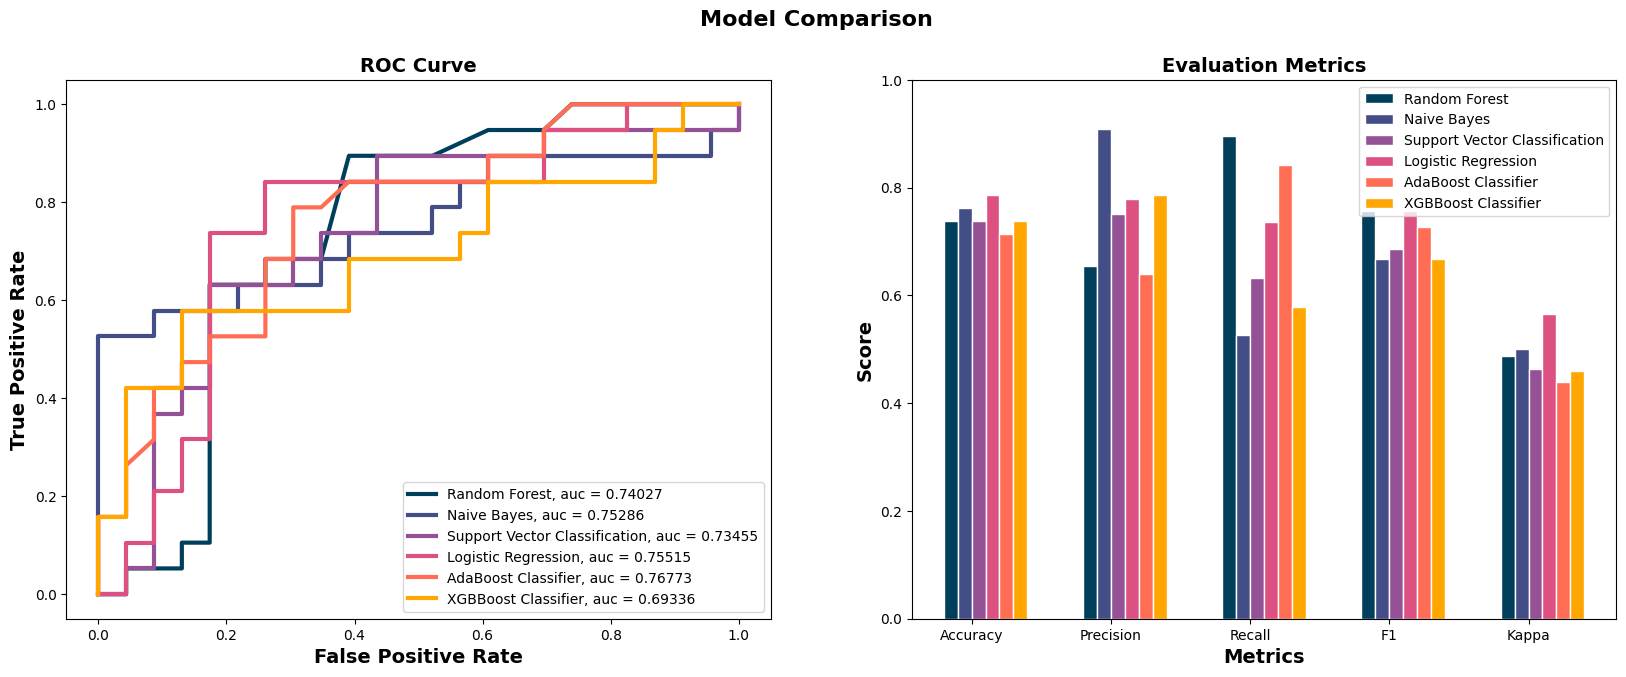

In [14]:
import numpy as np
# Intitialize figure with two plots
fig, (ax2,ax1) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(20)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.1
# dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
svc_score = [svc_eval['acc'], svc_eval['prec'], svc_eval['rec'], svc_eval['f1'], svc_eval['kappa']]
lr_score = [lr_eval['acc'], lr_eval['prec'], lr_eval['rec'], lr_eval['f1'],lr_eval['kappa']]
adab_score = [adab_eval['acc'], adab_eval['prec'], adab_eval['rec'], adab_eval['f1'],adab_eval['kappa']]
xgb_score = [xgb_eval['acc'], xgb_eval['prec'], xgb_eval['rec'], xgb_eval['f1'], xgb_eval['kappa']]

## Set position of bar on X axis
# r1 = np.arange(len(dtc_score))
r2=np.arange(len(rf_score))
# r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r5 = [x + barWidth for x in r3]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
# colors = ['#FF9E97', '#82CE9C', '#00B0F0', '#D854BF', '#7b7bb3','#E9DE09']
# colors=['#00876c','#6eaf9a','#b7d7cc','#f9c2c1','#eb8387','#d43d51']
# colors=['#fd7f6f', '#7eb0d5', '#b2e061', '#bd7ebe', '#ffb55a', '#ffee65', '#beb9db', '#fdcce5', '#8bd3c7']
colors=['#003f5c','#444e86','#955196','#dd5182','#ff6e54','#ffa600']

## Make the plot
# ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', color=colors[0], label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', color=colors[1], label='Naive Bayes')
ax1.bar(r5, svc_score, width=barWidth, edgecolor='white', color=colors[2], label='Support Vector Classification')
ax1.bar(r6, lr_score, width=barWidth, edgecolor='white', color=colors[3], label='Logistic Regression')
ax1.bar(r7, adab_score, width=barWidth, edgecolor='white', color=colors[4], label='AdaBoost Classifier')
ax1.bar(r8, xgb_score, width=barWidth, edgecolor='white', color=colors[5], label='XGBBoost Classifier')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold',fontsize=14)
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(rf_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold',fontsize=14)
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
# ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'],color=colors[0], linewidth=3, label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'],color=colors[1],linewidth=3, label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(svc_eval['fpr'], svc_eval['tpr'],color=colors[2],linewidth=3, label='Support Vector Classification, auc = {:0.5f}'.format(svc_eval['auc']))
ax2.plot(lr_eval['fpr'], lr_eval['tpr'],color=colors[3],linewidth=3, label='Logistic Regression, auc = {:0.5f}'.format(lr_eval['auc']))
ax2.plot(adab_eval['fpr'], adab_eval['tpr'],color=colors[4],linewidth=3, label='AdaBoost Classifier, auc = {:0.5f}'.format(adab_eval['auc']))
ax2.plot(xgb_eval['fpr'], xgb_eval['tpr'],color=colors[5],linewidth=3, label='XGBBoost Classifier, auc = {:0.5f}'.format(xgb_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold',fontsize=14)
ax2.set_ylabel('True Positive Rate', fontweight='bold',fontsize=14)

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

resolution_value = 700
plt.savefig("/content/drive/MyDrive/n2v/docs/myImage4.png", format="png", dpi=resolution_value)
plt.show()

# Target prediction

In [ ]:
df_rand=df_neg_all.sample(n=104)
df_rand=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_neg6.xlsx')
final_df=pd.concat([df_pos, df_rand], axis=0)

final_df=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_rf89.xlsx').drop(['Unnamed: 0'],1)
X=final_df.drop(['name','Label','Gene Names (primary)'],1)
Y=final_df['Label']
X_scaled = scaler.fit_transform(X)
X_train_0, X_test_0, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
k=35
selector = SelectKBest(score_func=chi2, k=k)

X_train = selector.fit_transform(X_train_0, Y_train)
X_test = selector.transform(X_test_0)



model = RandomForestClassifier(random_state=0)
# model=GaussianNB()
# model=AdaBoostClassifier(n_estimators=15, random_state=50)
# model = LogisticRegression(solver='liblinear')
model.fit(X_train, Y_train)
model_eval = evaluate_model(model, X_test, Y_test)

print('model Accuracy:', model_eval['acc'],'Precision:', model_eval['prec'],'recall:', model_eval['rec'])



<ipython-input-21-4a7b95fd96e0>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_df=pd.read_excel('/content/drive/MyDrive/n2v/models/high_acc_rf89.xlsx').drop(['Unnamed: 0'],1)
<ipython-input-21-4a7b95fd96e0>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=final_df.drop(['name','Label','Gene Names (primary)'],1)


model Accuracy: 0.7380952380952381 Precision: 0.6538461538461539 recall: 0.8947368421052632


In [ ]:
df_all=pd.concat([df_neg_all, df_rand]).drop_duplicates(keep=False)
X_new=df_all.drop(['name','Label','Gene Names (primary)'],1)
X_new_scaled = scaler.transform(X_new)
# k=37
# selector = SelectKBest(score_func=chi2, k=k)
X_new_best=selector.transform(X_new_scaled)

predictions = model.predict(X_new_best)
df_all_preds=df_all
df_all_preds['Predictions'] = predictions
df_all_preds=df_all_preds.drop(['Label'],1)

<ipython-input-22-8ccd6a6bc7d1>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_new=df_all.drop(['name','Label','Gene Names (primary)'],1)
<ipython-input-22-8ccd6a6bc7d1>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_all_preds=df_all_preds.drop(['Label'],1)


In [ ]:
df_pred_pos=df_all_preds[df_all_preds['Predictions']==1]

In [ ]:
df_pred_pos

,name,0,1,2,3,4,5,6,7,8,...,56,57,58,59,60,61,62,63,Gene Names (primary),Predictions
1,Q03989,0.548039,-0.057920,0.439885,0.192360,-0.062555,-0.378087,0.337409,0.002131,-0.158760,...,0.336419,-0.146507,-0.460260,0.275413,-0.041947,0.381027,0.336239,0.474457,ARID5A,1
5,Q9BXJ5,-0.191282,0.082738,0.400337,0.739396,-0.825651,-0.645687,-0.044260,0.113381,-0.802520,...,0.405403,-0.030754,-0.466399,0.503156,0.289555,0.714195,0.126193,-0.158793,C1QTNF2,1
9,Q99814,0.330385,-0.449169,0.797317,-0.676305,-0.699599,-0.233983,0.300920,-0.325237,-0.131634,...,-0.047374,-0.284050,-0.317751,-0.414230,0.277605,0.432582,0.505113,-0.251709,EPAS1,1
19,Q6FHY5,-0.198982,0.298936,0.049941,0.162134,0.119312,0.187721,-0.088857,-0.127244,-0.006216,...,0.005066,0.001253,-0.088983,0.438272,-0.139021,0.212872,0.203396,0.001596,MEOX2,1
25,P19237,0.664772,-0.282825,0.002044,1.002205,-0.089801,-0.409440,-0.362274,0.024224,0.143713,...,1.012990,0.245485,-0.519310,0.156040,-0.069837,0.087147,-0.125796,0.475956,TNNI1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,Q9UBM1,-0.048262,-0.575255,0.090159,-0.311556,-0.674554,-0.449428,-0.151289,-0.265174,0.585685,...,0.189421,-1.106604,-0.603431,0.830118,-0.142171,0.031793,-0.658930,-0.563073,PEMT,1
2638,Q9UF11,0.619882,-0.561447,0.131745,-0.125586,0.017655,-0.306746,0.206569,0.334435,0.130289,...,0.527902,-0.744656,-0.487552,0.467144,-0.494946,0.168132,-0.221993,0.608012,PLEKHB1,1
2640,Q9UGP5,-0.336101,-0.123228,-0.122980,-0.287436,-0.134326,-0.210560,0.567495,-0.283378,-0.544716,...,0.437693,-0.263608,-0.485984,0.381678,-0.178551,0.393740,-0.307364,0.349024,POLL,1
2645,Q9Y2I9,-0.156815,-0.220004,0.765559,0.226460,-0.184593,-0.697612,-0.112874,-0.349620,-0.437040,...,0.425362,-0.301002,-0.498778,0.115934,0.007744,0.477804,-0.134332,-0.458011,TBC1D30,1


In [ ]:
df_pred_pos[['name']]

,name
1,Q03989
5,Q9BXJ5
9,Q99814
19,Q6FHY5
25,P19237
...,...
2636,Q9UBM1
2638,Q9UF11
2640,Q9UGP5
2645,Q9Y2I9


In [ ]:
df_pred_pos[['name']].to_csv('/content/drive/MyDrive/n2v/pred_tar_rf.csv',index=False)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/imp_docs/Targets literature/Targets literature/Saha et al..txt", sep=" ", header=None)
df.columns=['Gene Names (primary)']

df_all=pd.concat([df_neg_all, df_rand]).drop_duplicates(keep=False)
df_saha=df.merge(df_all, on = 'Gene Names (primary)', how = 'left')
df_saha_targets=df_saha.dropna()
pd.merge(df_pred_pos, df_saha_targets, on='Gene Names (primary)', how='inner')

,name_x,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,55_y,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,Label
0,A0A024R8A9,-0.052067,-0.118017,0.170086,0.490211,-0.426910,-0.300862,0.266522,-0.424394,-0.320683,...,0.452738,0.872364,-0.454356,-0.739356,-0.081219,0.078016,0.337830,0.588410,-0.289243,0.0
1,Q03989,0.548039,-0.057920,0.439885,0.192360,-0.062555,-0.378087,0.337409,0.002131,-0.158760,...,-0.104186,0.336419,-0.146507,-0.460260,0.275413,-0.041947,0.381027,0.336239,0.474457,0.0
2,Q9H0I2,0.716198,-0.100946,0.272506,0.596902,-0.144892,-0.478320,-0.058313,0.257321,-0.449086,...,0.158137,0.405124,-0.061318,-0.565011,-0.169134,-0.469640,-0.209874,0.266621,-0.281057,0.0
3,Q99814,0.330385,-0.449169,0.797317,-0.676305,-0.699599,-0.233983,0.300920,-0.325237,-0.131634,...,0.634517,-0.047374,-0.284050,-0.317751,-0.414230,0.277605,0.432582,0.505113,-0.251709,0.0
4,Q9P0L0,-0.040448,-0.098941,0.171211,-0.104303,-0.812344,0.012874,0.332799,-0.331283,0.211688,...,0.230761,0.320366,-0.529358,-0.704613,-0.018109,-0.268600,0.372611,-0.229095,-0.540195,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,Q96S94,0.312808,-0.429523,-0.249434,0.699715,-0.133677,-0.714213,0.089970,-0.152854,-0.386690,...,-0.034710,0.837029,-0.469839,-0.712861,0.440593,0.414264,0.098147,0.083598,0.455525,0.0
487,Q9NNX6,0.581692,0.267534,0.264915,0.099672,0.510925,0.112801,-0.069925,-0.209375,0.054509,...,0.681027,0.159372,-0.360234,0.350799,0.559507,-0.203393,0.287311,-0.121525,-0.219118,0.0
488,Q9NNX6,0.581692,0.267534,0.264915,0.099672,0.510925,0.112801,-0.069925,-0.209375,0.054509,...,0.681027,0.159372,-0.360234,0.350799,0.559507,-0.203393,0.287311,-0.121525,-0.219118,0.0
489,Q9NNX6,0.581692,0.267534,0.264915,0.099672,0.510925,0.112801,-0.069925,-0.209375,0.054509,...,0.681027,0.159372,-0.360234,0.350799,0.559507,-0.203393,0.287311,-0.121525,-0.219118,0.0


In [ ]:
df_lit=pd.read_csv("/content/drive/MyDrive/n2v/literature/Copy of Barman et al..txt", sep=" ", header=None)
df_lit.columns=['Gene Names (primary)']


df_lit=df_lit.merge(df_all, on = 'Gene Names (primary)', how = 'left')
df_lit_targets=df_lit.dropna()

pd.merge(df_pred_pos, df_lit_targets, on='Gene Names (primary)', how='inner')

,name_x,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,55_y,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,Label
0,Q13084,0.160422,-0.345504,0.106368,0.780800,-0.083099,-0.478081,0.531426,0.078704,-0.538785,...,0.043356,0.545333,-0.009393,0.223739,-0.076198,0.264629,-0.068089,0.748474,-0.291869,0.0
1,Q6P1W5,0.448356,0.007162,-0.016949,0.146746,-0.164431,-0.281863,-0.236295,0.151285,0.268187,...,-0.241158,-0.037376,-0.260332,0.053717,0.737893,-0.175852,-0.021085,0.471689,0.269968,0.0
2,P68400,0.027862,-0.191210,0.189752,0.083158,-0.454945,0.103720,-0.107077,-0.265631,-0.309988,...,-0.467837,0.431954,0.234532,0.164381,0.656230,-0.184882,0.372827,-0.463704,-0.292210,0.0
3,Q5T749,0.030738,-0.237319,0.150055,-0.204799,0.381053,-0.216352,-0.720244,0.429765,-0.232272,...,-0.391383,-0.047120,-0.351710,-0.060657,0.507807,-0.362982,0.115896,0.026456,-0.089002,0.0
4,O43395,0.018256,-0.218735,0.934793,0.111321,-0.066058,-0.270799,-0.133697,-0.145268,-0.676059,...,-0.203518,0.858515,-0.090064,-0.061591,0.135601,-0.043571,-0.105402,0.450072,-0.382934,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Q9H892,0.911210,-0.222702,0.522044,0.166196,-0.515203,-0.639263,0.094267,-0.239802,-0.334421,...,0.897904,0.031082,0.853516,-0.652120,0.136038,0.102761,0.100212,0.490164,-0.063460,0.0
240,P04233,-0.072927,-0.518493,-0.055038,-0.815401,0.398284,-0.738041,0.712792,-0.142793,0.803060,...,0.259074,0.372445,-1.093976,0.036827,0.159236,-0.551282,0.398784,-0.732158,-0.651191,0.0
241,Q68DK2,0.078192,0.183953,0.576235,-0.156886,-0.228902,-0.261411,0.218795,-0.312763,-0.609219,...,0.241734,0.570683,-0.322687,-0.126315,0.140746,0.317288,0.264777,0.522566,0.364940,0.0
242,Q8IX01,-0.145038,0.118334,0.297618,0.085793,0.206908,-0.355649,0.457024,0.402606,0.066005,...,0.444923,0.784049,-0.738254,0.356972,0.149455,0.139122,0.029522,0.157512,-0.317302,0.0


In [ ]:
df_lit=pd.read_csv("/content/drive/MyDrive/n2v/literature/Copy of Tehrani et al..txt", sep=" ", header=None)
df_lit.columns=['Gene Names (primary)']


df_lit=df_lit.merge(df_all, on = 'Gene Names (primary)', how = 'left')
df_lit_targets=df_lit.dropna()

pd.merge(df_pred_pos, df_lit_targets, on='Gene Names (primary)', how='inner')

,name_x,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,55_y,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,Label
0,P08670,0.304477,0.312359,0.182093,-0.289092,0.150006,-0.438512,0.230528,0.178928,-0.086766,...,0.195487,-0.319099,0.227117,-0.485629,0.204539,-0.376853,-0.340142,-0.593841,0.109407,0.0
1,A0A0S2Z4E4,0.127997,-0.615755,-0.097910,0.274958,-0.720533,-0.722618,-0.610091,0.466451,-1.000224,...,0.021550,0.109262,-0.360093,-0.149726,-0.065998,-0.225829,0.364047,0.063833,-0.122810,0.0
2,A0A0S2Z4E4,0.127997,-0.615755,-0.097910,0.274958,-0.720533,-0.722618,-0.610091,0.466451,-1.000224,...,0.840247,0.241255,-0.191152,0.261308,-0.156323,-0.515391,0.500171,0.555708,0.184343,0.0
3,Q9UBB9,-0.062555,0.036562,0.108972,0.113003,-0.026363,-0.629338,0.123441,-0.357587,-0.404359,...,0.494960,-0.204274,-0.159351,-0.234005,0.342648,0.048132,-0.133399,-0.198475,-0.189088,0.0
4,P63165,-0.085820,-0.271776,-0.435268,-0.428932,-0.105205,0.123784,0.566942,0.300872,0.261744,...,0.263548,-0.042085,-0.037085,-0.187117,-0.493960,-0.488935,-0.149661,-0.248347,-0.070077,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Q12906,0.547042,-0.487479,0.169303,0.282551,-0.223750,-0.036470,0.286186,0.652911,-0.359940,...,-0.083593,0.288265,-0.606793,-0.365591,0.724472,-0.470641,0.254472,0.293013,-0.453327,0.0
98,Q12906,0.547042,-0.487479,0.169303,0.282551,-0.223750,-0.036470,0.286186,0.652911,-0.359940,...,0.815194,0.486588,-0.713767,-0.011508,0.346309,-0.663784,1.012017,0.098750,-0.129265,0.0
99,Q52LW3,0.634625,0.624785,-0.081078,0.142401,-0.097337,-0.226540,0.527985,0.127264,0.143555,...,0.132669,-0.177928,-0.660064,0.303427,0.243167,-0.432751,0.017394,-0.221638,-0.624161,0.0
100,Q8IX01,-0.145038,0.118334,0.297618,0.085793,0.206908,-0.355649,0.457024,0.402606,0.066005,...,0.444923,0.784049,-0.738254,0.356972,0.149455,0.139122,0.029522,0.157512,-0.317302,0.0
